# Classification

Guess what kind of wine is being reviewed

Ling 583  
March 8, 2019  
My name is Glen Heungyong Im (RedID: 823395723)  <p>
    
    
My best performance:<br>
(0.788025, 0.006157769482531792)
<p>
My best model:<br>
best_lo = make_pipeline(CountVectorizer(analyzer=identity),
                   TfidfTransformer(),
                   LogisticRegression(C=1.2067926406393288, penalty='l1'))
score = cross_val_score(best_lo, df['tokens'], df['wine_variant'], cv=folds, n_jobs=-1)

In [4]:
import pandas as pd
import numpy as np
from cytoolz import *
import spacy

import matplotlib.pyplot as plt

import seaborn as sns

%matplotlib inline

In [5]:
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.dummy import *
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import *
from sklearn.metrics import *

In [6]:
nlp = spacy.load('en')

## 1. Prepare data

Load and prepare the data

In [7]:
%%time

df = pd.read_msgpack('https://bit.ly/2Hk5Kly')

Wall time: 8.2 s


In [8]:
%%time

def tokenize(text):
    return [tok.orth_ for tok in nlp.tokenizer(text)]
df['tokens'] = df['review_text'].apply(tokenize)

Wall time: 3min 30s


## 2. Baseline

In [9]:
folds = StratifiedKFold(shuffle=True, n_splits=10, random_state=10)

In [10]:
baseline = DummyClassifier('most_frequent')

In [11]:
base_score = cross_val_score(baseline, df['tokens'], df['wine_variant'], cv=10)
base_score.mean(), base_score.std()

(0.25, 0.0)

## 3. Simple Logistic Regression

#### Simple Logistic Regression with Tf-Idf transform scales

In [12]:
lr2 = make_pipeline(CountVectorizer(analyzer=identity),
                   TfidfTransformer(),
                   LogisticRegression())

In [13]:
%%time

score = cross_val_score(lr2, df['tokens'], df['wine_variant'], cv=folds, n_jobs=-1)

Wall time: 1min 12s


In [25]:
score.mean(), score.std()

(0.7865, 0.0072783926797061445)

In [14]:
lr = make_pipeline(CountVectorizer(analyzer=identity), 
                   LogisticRegression())

In [12]:
%%time

Cs=  [1e-7, 1e-5, 0.1, 0.5, 0.75, 1.0, 1.5, 2.0, 5.0, 10.0, 20.0, 100.0]
train, valid = validation_curve(lr, df['tokens'], df['wine_variant'], 'logisticregression__C', Cs, cv=folds, n_jobs=-1)

Wall time: 54min 7s


Text(0, 0.5, 'score')

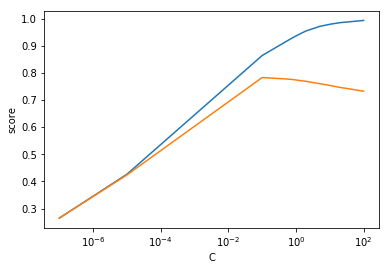

In [13]:
plt.plot(Cs,np.mean(train, axis=1))
plt.plot(Cs,np.mean(valid, axis=1))
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('score')

#### Simple Logistic Regression

In [26]:
score = cross_val_score(lr, df['tokens'], df['wine_variant'], cv=folds, n_jobs=-1)
score.mean(), score.std()

(0.2647, 0.0016232683080747937)

In [16]:
%%time

results3 = [ ]
lr.set_params(countvectorizer__min_df=5)

Wall time: 999 µs


In [18]:
lr

Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer=<cyfunction identity at 0x000002CC39B529A0>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=5, ngram_range=(1, 1), p...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [19]:
lr2

Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer=<cyfunction identity at 0x000002CC39B529A0>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), p...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

## 4. Best classifier pipeline

Started from MultinomialNB

In [29]:
from sklearn.naive_bayes import *

In [31]:
best_nb = make_pipeline(CountVectorizer(analyzer=identity), MultinomialNB())

In [32]:
min_dfs = [1, 2, 3, 5, 10, 15, 20, 25, 50, 100]
train, valid = validation_curve(best_nb, 
                                df['tokens'], 
                                df['wine_variant'], 
                                'countvectorizer__min_df',
                                min_dfs,
                                cv=folds, n_jobs=-1)

Text(0, 0.5, 'score')

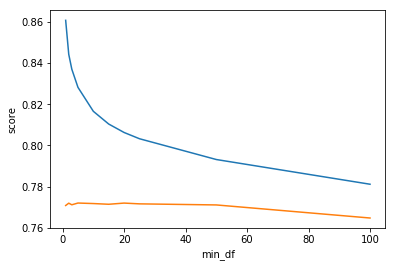

In [33]:
plt.plot(min_dfs,np.mean(train, axis=1))
plt.plot(min_dfs,np.mean(valid, axis=1))
plt.xlabel('min_df')
plt.ylabel('score')

In [34]:
%%time

best_nb.set_params(countvectorizer__min_df=1)
alphas = [1e-7, 1e-5, 0.1, 0.5, 0.75, 1.0, 1.5, 2.0, 5.0, 10.0, 20.0, 100.0]
train, valid = validation_curve(best_nb, 
                                df['tokens'], 
                                df['wine_variant'], 
                                'multinomialnb__alpha',
                                alphas,
                                cv=folds, n_jobs=-1)

Wall time: 8min 3s


Text(0, 0.5, 'score')

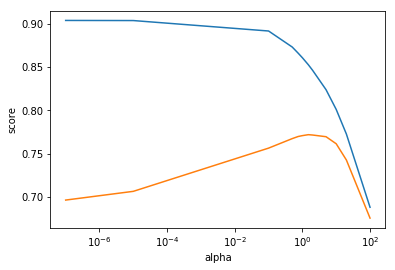

In [35]:
plt.plot(alphas,np.mean(train, axis=1))
plt.plot(alphas,np.mean(valid, axis=1))
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('score')

In [37]:
%%time

results = [ ]

for min_df in [1, 2, 3, 5, 10, 20]:
    best_nb.set_params(countvectorizer__min_df=min_df)
    sizes, train, valid = learning_curve(best_nb, 
                                         df['tokens'], 
                                         df['wine_variant'], 
                                         train_sizes=np.linspace(0.1, 1.0, num=10),
                                         cv=folds, n_jobs=-1)
    results.extend((min_df, sizes[i], t, v) for i in range(len(sizes)) 
                                    for t,v in zip(train[i], valid[i]))

Wall time: 25min 29s


In [38]:
df1 = pd.DataFrame(results, columns=['min_df', 'n', 'train', 'valid'])
df1 = df1.melt(id_vars=['n', 'min_df'], value_vars=['train', 'valid'], var_name='type', value_name='score')

In [39]:
sns.set_context('talk')
sns.set_style({'axes.grid':True, 
               'grid.color':'0.9',
            'axes.spines.left':False,'axes.spines.bottom':False})

C:\Users\Glen\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


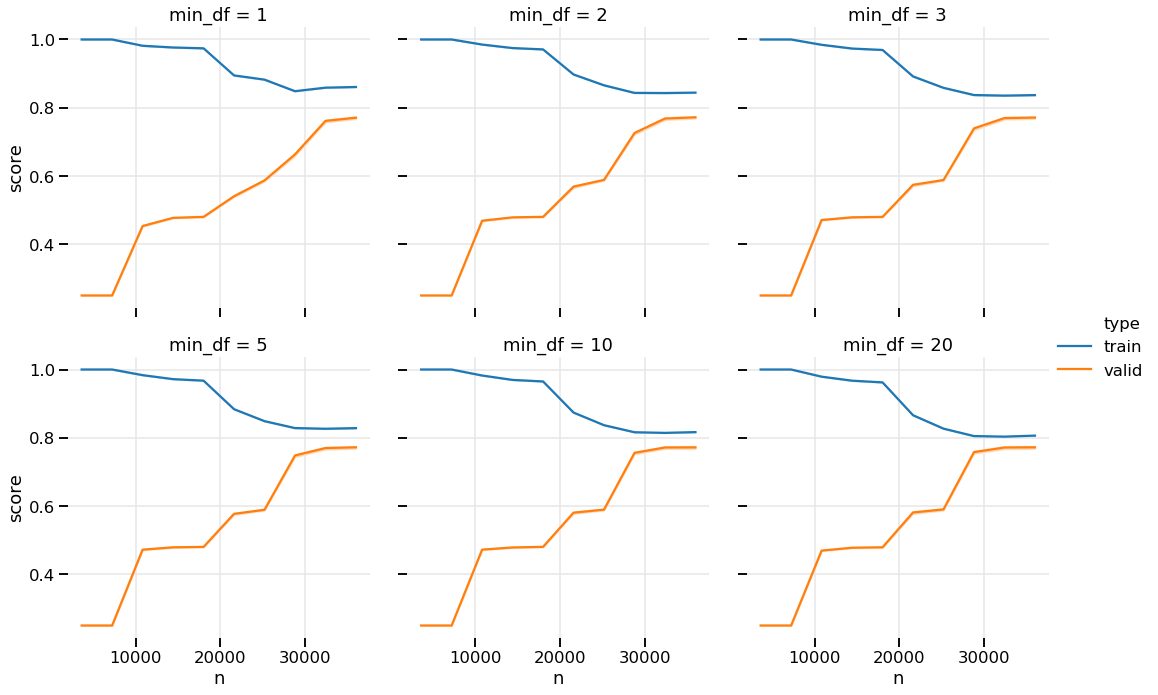

In [40]:
sns.relplot(x='n', y='score', hue='type', col='min_df', kind='line', data=df1, col_wrap=3)
sns.despine(left=True, bottom=True)

In [41]:
%%time

best_nb.set_params(countvectorizer__min_df=1)
results2 = [ ]
for alpha in [1e-7, 0.1, 0.5, 1.0, 2.0, 10.0]:
    best_nb.set_params(multinomialnb__alpha=alpha)
    sizes, train, valid = learning_curve(best_nb, 
                                         df['tokens'], 
                                         df['wine_variant'], 
                                         train_sizes=np.linspace(0.1, 1.0, num=10),
                                         cv=folds, n_jobs=-1)
    results2.extend((alpha, sizes[i], t, v) for i in range(len(sizes)) 
                                    for t,v in zip(train[i], valid[i]))

Wall time: 27min 4s


In [42]:
df2 = pd.DataFrame(results2, columns=['alpha', 'n', 'train', 'valid'])
df2 = df2.melt(id_vars=['n', 'alpha'], value_vars=['train', 'valid'], var_name='type', value_name='score')

C:\Users\Glen\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


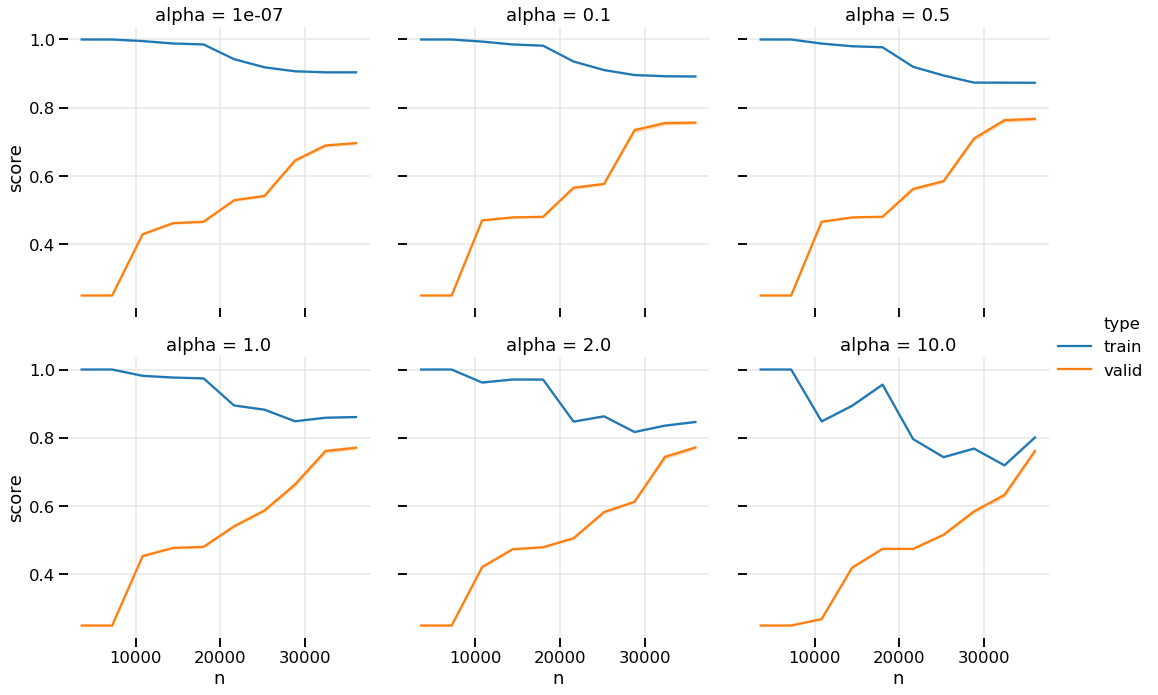

In [43]:
sns.relplot(x='n', y='score', hue='type', col='alpha', kind='line', data=df2, col_wrap=3)
sns.despine(left=True, bottom=True)

In [44]:
%%time
params = {'countvectorizer__min_df':[0.1, 0.5, 1, 20],
          'multinomialnb__alpha':[0.1,0.5,1.0]}
grid_search = GridSearchCV(best_nb, params, n_jobs=-1, verbose=1, cv=folds, return_train_score=True)
grid_search.fit(df['tokens'], df['wine_variant'])
grid_search.best_params_

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  7.0min finished


Wall time: 7min 1s


In [47]:
grid_search.best_params_

{'countvectorizer__min_df': 20, 'multinomialnb__alpha': 1.0}

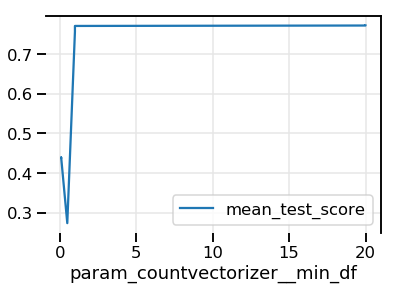

In [46]:
%matplotlib inline

grid = pd.DataFrame(grid_search.cv_results_, dtype=float)
grid.plot.line('param_countvectorizer__min_df', 'mean_test_score')

In [77]:
best_nb = make_pipeline(CountVectorizer(min_df=20, analyzer=identity), MultinomialNB(alpha=1.0))

score = cross_val_score(best_nb, df['tokens'], df['wine_variant'], cv=folds, n_jobs=-1)
score.mean(), score.std()

(0.772025, 0.006770755127753485)

The result is not better than the logistic regression with Tf-Idf transform scale, 
But conducted error analysis to draw some insights from errors.

## 5. Error analysis and discussion

Create a classification report and confusion matrix

In [182]:
itrain, itest = first(folds.split(df['tokens'], 
                                  df['wine_variant']))
train = df.iloc[itrain]
test = df.iloc[itest]

In [183]:
best_nb.fit(train['tokens'], train['wine_variant'])
pred = best_nb.predict(test['tokens'])

In [184]:
print(classification_report(test['wine_variant'], pred))

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.71      0.69      0.70      1000
        Chardonnay       0.86      0.82      0.84      1000
            Merlot       0.69      0.74      0.72      1000
   Sauvignon Blanc       0.86      0.85      0.85      1000

         micro avg       0.78      0.78      0.78      4000
         macro avg       0.78      0.78      0.78      4000
      weighted avg       0.78      0.78      0.78      4000



In [185]:
confusion_matrix(test['wine_variant'], pred)

array([[693,  14, 288,   5],
       [ 36, 823,  23, 118],
       [234,   9, 744,  13],
       [ 18, 116,  18, 848]], dtype=int64)

In [58]:
from sklearn.utils.multiclass import unique_labels

def plot_cm(true, pred, cmap=plt.cm.Blues):
    cm = confusion_matrix(true, pred)
    classes = unique_labels(true)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title='Confusion matrix',
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

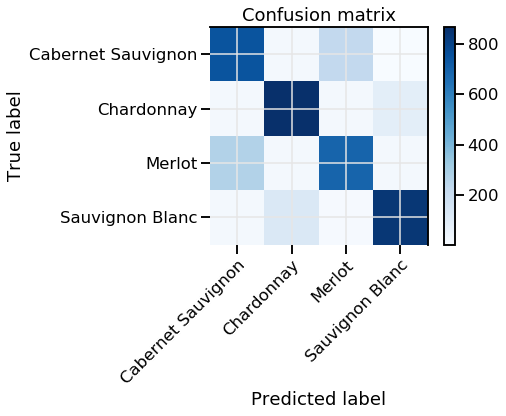

In [82]:
plot_cm(test['wine_variant'], pred)

In [187]:
test[test['wine_variant']!=pred]

,wine_variant,review_text,tokens
8,Cabernet Sauvignon,"Sweet red fruits and still a bit of tannins, but everything is well integrated in this wine. It has some real nice cherry flavors and a hint of tobacco. The finish is smooth and silky.","[Sweet, red, fruits, and, still, a, bit, of, tannins, ,, but, everything, is, well, integrated, in, this, wine, ., It, has, some, real, nice, cherry, flavors, and, a, hint, of, tobacco, ., The, finish, is, smooth, and, silky, .]"
131,Cabernet Sauvignon,"Begins with blueberry, bitter chocolate and cassis. The palate shows dried blue fruit, cracked pepper and sage. Rustic and brawny in feel with firm tannin and full finishing notes. Very nice.","[Begins, with, blueberry, ,, bitter, chocolate, and, cassis, ., The, palate, shows, dried, blue, fruit, ,, cracked, pepper, and, sage, ., Rustic, and, brawny, in, feel, with, firm, tannin, and, full, finishing, notes, ., Very, nice, .]"
...,...,...,...
39875,Sauvignon Blanc,"Not bad, but nothing special. Could sense a bit of oak. Good apple and melon flavors, just nothing that stood out.","[Not, bad, ,, but, nothing, special, ., Could, sense, a, bit, of, oak, ., Good, apple, and, melon, flavors, ,, just, nothing, that, stood, out, .]"
39957,Sauvignon Blanc,"Cork crumbled and so I had to double decant via some filter bags. Sauternes colour, and a bit of fruit on the nose. No denying the age, but there was an earthy tangerine taste. Dry on the finish though. Just drinkable.","[Cork, crumbled, and, so, I, had, to, double, decant, via, some, filter, bags, ., Sauternes, colour, ,, and, a, bit, of, fruit, on, the, nose, ., No, denying, the, age, ,, but, there, was, an, earthy, tangerine, taste, ., Dry, on, the, finish, though, ., Just, drinkable, .]"


In [89]:
best_nb.named_steps

{'countvectorizer': CountVectorizer(analyzer=<cyfunction identity at 0x000002CC39B529A0>,
         binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
         encoding='utf-8', input='content', lowercase=True, max_df=1.0,
         max_features=None, min_df=20, ngram_range=(1, 1),
         preprocessor=None, stop_words=None, strip_accents=None,
         token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None),
 'multinomialnb': MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)}

In [90]:
best_nb.named_steps['multinomialnb'].classes_

array(['Cabernet Sauvignon', 'Chardonnay', 'Merlot', 'Sauvignon Blanc'],
      dtype='<U18')

In [200]:
best_nb.named_steps['multinomialnb'].coef_

array([[ -7.54870512,  -6.00616144,  -6.60485644, ..., -12.46136   ,
        -12.46136   , -11.20859704],
       [ -7.54987334,  -6.23157633,  -6.60607596, ..., -10.24211293,
        -10.43626895, -10.51037692],
       [ -7.61081816,  -6.19412632,  -6.54143551, ..., -12.00526731,
        -12.00526731, -10.53893024],
       [ -8.15311104,  -6.16173851,  -6.53134631, ...,  -9.71708658,
         -9.20626095,  -9.10090044]])

In [201]:
np.argsort(best_nb.named_steps['multinomialnb'].coef_[0])

array([2165, 2507,  246, ..., 1129,   19,   24], dtype=int64)

In [202]:
X = np.array(best_nb.named_steps['countvectorizer'].get_feature_names())
terms = X[np.argsort(best_nb.named_steps['multinomialnb'].coef_[0])]

Based on those keywords, the terms that classifies negative are quite neutral or grammar words, such as 'I', 'of', 'the', 'and', etc.
This tells the performance could be improved by tagging grammar entitires and make the classifier ignore those terms.

In [203]:
terms[-50:], terms[:50]

(array(['little', 'years', 'an', 'bit', 'A', 'have', 'cherry', 'had', "'s",
        'red', 'oak', 'well', 'nice', 'black', 'as', 'This', 'The', 'good',
        'palate', 'bottle', 'more', 'at', 'some', 'dark', 'very', 'not',
        'that', 'tannins', 'finish', 'nose', 'for', '-', 'was', 'in', 'on',
        'is', 'fruit', 'this', 'it', 'wine', 'but', 'I', 'to', 'with',
        'of', 'a', 'the', 'and', ',', '.'], dtype='<U23'),
 array(['golden', 'limes', 'Burgundian', 'guava', 'Fevre', 'Lemons',
        'citric', 'citris', 'chards', 'lemony', 'lemons', 'citrusy',
        'clams', 'porch', 'stonefruit', 'Bourgogne', 'cleansing',
        'citrussy', 'Lemony', 'chardonnays', 'chard', 'butteriness',
        'Pears', 'tangerine', 'Pear', 'Peach', 'mandarin', 'sb',
        'Leflaive', 'cantaloupe', 'sushi', 'Paloma', 'Pale', 'fatter',
        'chablis', 'Aubert', 'Butterscotch', 'scallops', 'pith', 'steely',
        'colder', 'Grass', 'smith', 'honeyed', 'Meursault', 'quince',
        'honeyd

In [96]:
best_nb.predict_proba(test['tokens'])

array([[3.72940034e-01, 2.58585585e-09, 6.27059964e-01, 3.30214261e-11],
       [9.99997818e-01, 6.60885936e-21, 2.18244606e-06, 6.50258718e-25],
       [9.87884720e-01, 8.03260777e-08, 1.21151972e-02, 2.90921936e-09],
       ...,
       [4.99173484e-10, 7.13218814e-04, 1.57281681e-09, 9.99286779e-01],
       [1.19379508e-15, 6.79010623e-07, 5.47998766e-14, 9.99999321e-01],
       [2.47513294e-07, 1.49398557e-03, 6.13927235e-07, 9.98505153e-01]])

In [97]:
cab = best_nb.predict_proba(test['tokens'])[:,0]

In [98]:
test.iloc[np.argsort(cab)]['review_text']

37665    This is a very good, not outstanding SB. In the glass it was a pale yellow with some nice greenish tinting to it. Really lovely to look at. Light floral aromas meshed with lemon zest, gooseberry and wet grass on the nose. The flavor profile revealed bright citrus, grapefruit for sure, some minerality and the SB cliche of wet stones. This wine has nice balance with a very crisp acidity which makes it very refreshing. Really well integrated with a light mouth feel the finish was medium in leng...
33951    Clear, star bright, very pale silvery straw with watery rim. Low viscocity with sheeting on the glass. NOSE: moderate intensity, ruby red grapefruit, unripe pineapple, fresh green grass, fresh white flowers, lemon peel, lychee. PALATE: green grass, canned peas, grapefruit, lemon rind. Medium acidity with 13.5% alcohol. Medium to medium plus finish, medium complexity. I would have like a little more acidity to keep the palate going. It paired well with chicken picata. Would also

In [ ]:
test['cab'] = cab

In [ ]:
test[abs(test['cab']-0.0) > 0.5]

Based on the error analysis, I found out some errors with high confidence classified as 'Carbernet Sauvignon' are just as ambiguous to me.
In my opinion, those 'ambiguous reviews' are better left to be ambiguous, or trying to fit those could lead to over-fitting.
This time, I tried 'MultinomialNB' with 'TfidfTransformer.'

In [108]:
best_tf = make_pipeline(CountVectorizer(analyzer=identity),
                        TfidfTransformer(),
                        MultinomialNB())

In [111]:
%%time
params = {'countvectorizer__min_df':[0.5, 1, 10, 20, 50],
          'multinomialnb__alpha':[0.01, 0.1, 0.5, 1.0, 2.0]}
grid_search = GridSearchCV(best_nb, params, n_jobs=-1, verbose=1, cv=folds, return_train_score=True)
grid_search.fit(df['tokens'], df['wine_variant'])

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 13.9min finished


Wall time: 13min 57s


In [112]:
grid_search.best_params_

{'countvectorizer__min_df': 20, 'multinomialnb__alpha': 1.0}

In [113]:
best_tf = make_pipeline(CountVectorizer(analyzer=identity, min_df=20),
                        TfidfTransformer(),
                        MultinomialNB(alpha=1.0))
score = cross_val_score(best_tf, df['tokens'], df['wine_variant'], cv=folds, n_jobs=-1)
score.mean(), score.std()

(0.766825, 0.006203879834426211)

In [116]:
best_tf = make_pipeline(CountVectorizer(analyzer=identity, ngram_range=(1,2), binary=True),
                        TfidfTransformer(), 
                        MultinomialNB())

In [117]:
%%time
params = {'countvectorizer__min_df':[0.5, 1, 10, 20, 50],
          'multinomialnb__alpha':[0.01, 0.1, 0.5, 1.0, 2.0]}
grid_search = GridSearchCV(best_nb, params, n_jobs=-1, verbose=1, cv=folds, return_train_score=True)
grid_search.fit(df['tokens'], df['wine_variant'])

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 19.0min finished


Wall time: 19min 2s


In [118]:
grid_search.best_params_

{'countvectorizer__min_df': 20, 'multinomialnb__alpha': 1.0}

In [119]:
best_tf = make_pipeline(CountVectorizer(analyzer=identity, ngram_range=(1,2), binary=True, min_df=20),
                        TfidfTransformer(), 
                        MultinomialNB(alpha=1.0))
score = cross_val_score(best_tf, df['tokens'], df['wine_variant'], cv=folds, n_jobs=-1)
score.mean(), score.std()

(0.76495, 0.006862761834713475)

In [120]:
itrain, itest = first(folds.split(df['tokens'], 
                                  df['wine_variant']))
train = df.iloc[itrain]
test = df.iloc[itest]

In [122]:
best_tf.fit(train['tokens'], train['wine_variant'])
pred = best_tf.predict(test['tokens'])

In [123]:
confusion_matrix(test['wine_variant'], pred)

array([[692,  16, 287,   5],
       [ 42, 818,  27, 113],
       [250,   9, 730,  11],
       [ 19, 121,  16, 844]], dtype=int64)

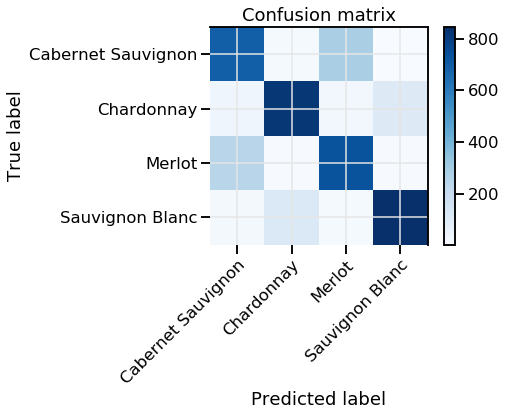

In [166]:
plot_cm(test['wine_variant'], pred)

In [126]:
test[test['wine_variant']!=pred]

,wine_variant,review_text,tokens
8,Cabernet Sauvignon,"Sweet red fruits and still a bit of tannins, but everything is well integrated in this wine. It has some real nice cherry flavors and a hint of tobacco. The finish is smooth and silky.","[Sweet, red, fruits, and, still, a, bit, of, tannins, ,, but, everything, is, well, integrated, in, this, wine, ., It, has, some, real, nice, cherry, flavors, and, a, hint, of, tobacco, ., The, finish, is, smooth, and, silky, .]"
131,Cabernet Sauvignon,"Begins with blueberry, bitter chocolate and cassis. The palate shows dried blue fruit, cracked pepper and sage. Rustic and brawny in feel with firm tannin and full finishing notes. Very nice.","[Begins, with, blueberry, ,, bitter, chocolate, and, cassis, ., The, palate, shows, dried, blue, fruit, ,, cracked, pepper, and, sage, ., Rustic, and, brawny, in, feel, with, firm, tannin, and, full, finishing, notes, ., Very, nice, .]"
149,Cabernet Sauvignon,"I really hope to rate this higher over time, but at present hits me as so sweet that I'd rather pair it with bitter chocolate for dessert than any main course I can think of.","[I, really, hope, to, rate, this, higher, over, time, ,, but, at, present, hits, me, as, so, sweet, that, I, 'd, rather, pair, it, with, bitter, chocolate, for, dessert, than, any, main, course, I, can, think, of, .]"
166,Cabernet Sauvignon,"For $20 worth the money featuring cherry, plum, oak, vanilla and mild spices. Not a big wine and balanced. Drink now.","[For, $, 20, worth, the, money, featuring, cherry, ,, plum, ,, oak, ,, vanilla, and, mild, spices, ., Not, a, big, wine, and, balanced, ., Drink, now, .]"
191,Cabernet Sauvignon,"Berries, some vanilla on the nose. Sweet fruit on the palate. Tannins have almost faded. Probably should have drunk this earlier. Feels unbalanced now, too sweet without enough acidity. Still, very drinkable as aperitif; didn't enjoy as accompaniment to tuna steak yesterday.","[Berries, ,, some, vanilla, on, the, nose, ., Sweet, fruit, on, the, palate, ., Tannins, have, almost, faded, ., Probably, should, have, drunk, this, earlier, ., Feels, unbalanced, now, ,, too, sweet, without, enough, acidity, ., Still, ,, very, drinkable, as, aperitif, ;, did, n't, enjoy, as, accompaniment, to, tuna, steak, yesterday, .]"
213,Cabernet Sauvignon,Drank w/SPO last night.. Agree about the dynamic status of the wine. Not sure if it was the wonder food at Blue Boheme or if it was truely the wine. Noticed plums on the palate. Not typical over the top Napa Cab.. enjoyable but not a knockout either.,"[Drank, w, /, SPO, last, night, .., Agree, about, the, dynamic, status, of, the, wine, ., Not, sure, if, it, was, the, wonder, food, at, Blue, Boheme, or, if, it, was, truely, the, wine, ., Noticed, plums, on, the, palate, ., Not, typical, over, the, top, Napa, Cab, .., enjoyable, but, not, a, knockout, either, .]"
233,Cabernet Sauvignon,"Surprisingly good. You just never know. Complex, nice blueberry, chocolate, and a bit smokey in the background.","[Surprisingly, good, ., You, just, never, know, ., Complex, ,, nice, blueberry, ,, chocolate, ,, and, a, bit, smokey, in, the, background, .]"
333,Cabernet Sauvignon,"Big earthy, funky nose on this wine. It's a little hot and sharp. This just isn't a style of wine that I enjoy drinking. I really prefer the Malbec that Sagelands makes.","[Big, earthy, ,, funky, nose, on, this, wine, ., It, 's, a, little, hot, and, sharp, ., This, just, is, n't, a, style, of, wine, that, I, enjoy, drinking, ., I, really, prefer, the, Malbec, that, Sagelands, makes, .]"
368,Cabernet Sauvignon,Robust and very satisfying. Taste of plum and dark berries. Serve at 15C for best results. Very good wine for the price.,"[Robust, and, very, satisfying, ., Taste, of, plum, and, dark, berries, ., Serve, at, 15C, for, best, results, ., Very, good, wine, for, the, price, .]"
413,Cabernet Sauvignon,No decanting and drank immediately after opening. Color is still good with deep garnet and only a sligh

In [127]:
best_tf.named_steps

{'countvectorizer': CountVectorizer(analyzer=<cyfunction identity at 0x000002CC39B529A0>,
         binary=True, decode_error='strict', dtype=<class 'numpy.int64'>,
         encoding='utf-8', input='content', lowercase=True, max_df=1.0,
         max_features=None, min_df=20, ngram_range=(1, 2),
         preprocessor=None, stop_words=None, strip_accents=None,
         token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None),
 'tfidftransformer': TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True),
 'multinomialnb': MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)}

At this moment, I combined all terms in all 4 class

In [151]:
X = np.array(best_tf.named_steps['countvectorizer'].get_feature_names())
terms_carb = X[np.argsort(best_tf.named_steps['multinomialnb'].coef_[0])]
terms_char = X[np.argsort(best_tf.named_steps['multinomialnb'].coef_[1])]
terms_merl = X[np.argsort(best_tf.named_steps['multinomialnb'].coef_[2])]
terms_blan = X[np.argsort(best_tf.named_steps['multinomialnb'].coef_[3])]

In [152]:
terms_combined = np.array([terms_carb,terms_char,terms_merl,terms_blan])

In [159]:
terms_carb, terms_char, terms_merl, terms_blan

(array(['Fume', 'piercing', 'citrussy', ..., ',', 'and', '.'], dtype='<U23'),
 array(['aerator', 'Duckhorn', 'bricking', ..., 'and', ',', '.'],
       dtype='<U23'),
 array(['pesto', 'Meyer', 'Meursault', ..., ',', 'and', '.'], dtype='<U23'),
 array(['tenderloin', 'Toasty', 'haul', ..., ',', 'and', '.'], dtype='<U23'))

In [181]:
terms_carb[-50:]

array(['had', 'still', 'color', 'A', 'The', 'Very', 'cassis', 'now',
       'years', 'oak', 'This', 'red', 'well', 'that', 'nice', 'cherry',
       'palate', 'some', 'more', 'good', 'at', 'cab', 'bottle', 'not',
       'very', 'black', '-', 'is', 'was', 'dark', 'in', 'on', 'I', 'it',
       'nose', 'for', 'finish', 'this', 'to', 'wine', 'but', 'tannins',
       'of', 'with', 'fruit', 'the', 'a', ',', 'and', '.'], dtype='<U23')

In [161]:
carb = best_tf.predict_proba(test['tokens'])[:,0]
char = best_tf.predict_proba(test['tokens'])[:,1]
merl = best_tf.predict_proba(test['tokens'])[:,2]
blan = best_tf.predict_proba(test['tokens'])[:,3]

In [163]:
test['carb'] = carb
test['char'] = char
test['merl'] = merl
test['blan'] = blan

C:\Users\Glen\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Glen\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Glen\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

In [164]:
test[abs(test['carb']-0.0) < 0.01]
test[abs(test['char']-0.0) < 0.01]
test[abs(test['merl']-0.0) < 0.01]
test[abs(test['blan']-0.0) < 0.01]

,wine_variant,review_text,tokens,carb,char,merl,blan
8,Cabernet Sauvignon,"Sweet red fruits and still a bit of tannins, but everything is well integrated in this wine. It has some real nice cherry flavors and a hint of tobacco. The finish is smooth and silky.","[Sweet, red, fruits, and, still, a, bit, of, tannins, ,, but, everything, is, well, integrated, in, this, wine, ., It, has, some, real, nice, cherry, flavors, and, a, hint, of, tobacco, ., The, finish, is, smooth, and, silky, .]",0.477312,0.011601,0.505560,0.005526
32,Cabernet Sauvignon,"When I bought this 9 years ago, I commented that it was extremely tannic and would take years to evolve. Jancis Robinsonm and I agreed that the 94 Napa vintage required patience. I thought 14 years would do. It needs more time. I double decanted in the morning. At dinner at Prime 112, it was still austere, so we used the Vinturi aerator and it finally began to reveal itself. Classic Medoc styled Cab with brooding cassis graphite palate.If you want to drink it, either decant for several hours...","[When, I, bought, this, 9, years, ago, ,, I, commented, that, it, was, extremely, tannic, and, would, take, years, to, evolve, ., Jancis, Robinsonm, and, I, agreed, that, the, 94, Napa, vintage, required, patience, ., I, thought, 14, years, would, do, ., It, needs, more, time, ., I, double, decanted, in, the, morning, ., At, dinner, at, Prime, 112, ,, it, was, still, austere, ,, so, we, used, the, Vinturi, aerator, and, it, finally, began, to, reveal, itself, ., Classic, Medoc, styled, Cab, ...",0.802589,0.011081,0.181684,0.004646
126,Cabernet Sauvignon,"dark ruby and plenty of ""terrior"", nose is a bit earthy...must decant for at least 1 hour. after it opened up, it mellowed nicely and became very drinkable","[dark, ruby, and, plenty, of, "", terrior, "", ,, nose, is, a, bit, earthy, ..., must, decant, for, at, least, 1, hour, ., after, it, opened, up, ,, it, mellowed, nicely, and, became, very, drinkable]",0.532233,0.012266,0.447622,0.007879
129,Cabernet Sauvignon,"Tasted at vertical Chateau Montelena tasting at the home of Amy Weinberg. Bright disc. Opaque ruby with red rim. Clean nose, showing moderately intense currants, cherry, plum and mint. Medium to full-bodied on the palate, with medium sweet tannins and similar flavors as for the nose. Long, smooth finish. This wine is showing a very youthful face for an '86. Should continue to improve.","[Tasted, at, vertical, Chateau, Montelena, tasting, at, the, home, of, Amy, Weinberg, ., , Bright, disc, ., , Opaque, ruby, with, red, rim, ., , Clean, nose, ,, showing, moderately, intense, currants, ,, cherry, ,, plum, and, mint, ., , Medium, to, full, -, bodied, on, the, palate, ,, with, medium, sweet, tannins, and, similar, flavors, as, for, the, nose, ., , Long, ,, smooth, finish, ., , This, wine, is, showing, a, very, youthful, face, for, an, ', 86, ., , Should, continue, to, im...",0.742251,0.014967,0.237951,0.004831
131,Cabernet Sauvignon,"Begins with blueberry, bitter chocolate and cassis. The palate shows dried blue fruit, cracked pepper and sage. Rustic and brawny in feel with firm tannin and full finishing notes. Very nice.","[Begins, with, blueberry, ,, bitter, chocolate, and, cassis, ., The, palate, shows, dried, blue, fruit, ,, cracked, pepper, and, sage, ., Rustic, and, brawny, in, feel, with, firm, tannin, and, full, finishing, notes, ., Very, nice, .]",0.461282,0.003795,0.527067,0.007857
145,Cabernet Sauvignon,"Although this was a great wine, it was definitely way too young to drink, and could sit in the bottle for at least another 10 years an be absolutely incredible. Purchased this down in Lavalette, NJ this weekend while visiting Todd & Michelle's beach house. Gorgeous fragrances right as the bottle was opened, and you could really smell this wine. This was put back into the cellar for a few hours while we drank the previous whites, and it really opened up overtime. Nice hints of blackberry, dar...","[Although, this, was, a, gr

Found the paper below, and tried applying BernoulliNB

http://www.cs.cmu.edu/~knigam/papers/multinomial-aaaiws98.pdf

In [168]:
best_bn = make_pipeline(CountVectorizer(analyzer=identity),
                        TfidfTransformer(),
                        BernoulliNB())

In [169]:
%%time
params = {'countvectorizer__min_df':[0.5, 1, 10, 20, 50],
          'bernoullinb__alpha':[0.01, 0.1, 0.5, 1.0, 2.0]}
grid_search = GridSearchCV(best_bn, params, n_jobs=-1, verbose=1, cv=folds, return_train_score=True)
grid_search.fit(df['tokens'], df['wine_variant'])


Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 13.0min finished


Wall time: 13min


In [170]:
grid_search.best_params_

{'bernoullinb__alpha': 1.0, 'countvectorizer__min_df': 10}

In [173]:
best_bn = make_pipeline(CountVectorizer(analyzer=identity, min_df=10),
                        TfidfTransformer(),
                        BernoulliNB(alpha=1.0))
score = cross_val_score(best_tf, df['tokens'], df['wine_variant'], cv=folds, n_jobs=-1)
score.mean(), score.std()

(0.7573749999999999, 0.007023398393940072)

Failing to getting better performance in other methods, I chose to improve logistic regression by tuning parameters.

In [177]:
best_lo = make_pipeline(CountVectorizer(analyzer=identity),
                   TfidfTransformer(),
                   LogisticRegression())

In [178]:
best_lo.get_params().keys()

dict_keys(['memory', 'steps', 'countvectorizer', 'tfidftransformer', 'logisticregression', 'countvectorizer__analyzer', 'countvectorizer__binary', 'countvectorizer__decode_error', 'countvectorizer__dtype', 'countvectorizer__encoding', 'countvectorizer__input', 'countvectorizer__lowercase', 'countvectorizer__max_df', 'countvectorizer__max_features', 'countvectorizer__min_df', 'countvectorizer__ngram_range', 'countvectorizer__preprocessor', 'countvectorizer__stop_words', 'countvectorizer__strip_accents', 'countvectorizer__token_pattern', 'countvectorizer__tokenizer', 'countvectorizer__vocabulary', 'tfidftransformer__norm', 'tfidftransformer__smooth_idf', 'tfidftransformer__sublinear_tf', 'tfidftransformer__use_idf', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_intercept', 'logisticregression__intercept_scaling', 'logisticregression__max_iter', 'logisticregression__multi_class', 'logisticregression__n_jobs', 'logisticreg

In [179]:
params = {'logisticregression__C':np.logspace(-4, 4, 50),
          'logisticregression__penalty':['l1', 'l2']}
grid_search = GridSearchCV(best_lo, params, n_jobs=-1, verbose=1, cv=folds, return_train_score=True)
grid_search.fit(df['tokens'], df['wine_variant'])

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 30.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 98.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 166.8min finished
C:\Users\Glen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Glen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=10, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer=<cyfunction identity at 0x000002CC39B529A0>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), p...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'logisticregression__C': array([1.00000e-04, 1.45635e-04, 2.12095e-04, 3.08884e-04, 4.49843e-04,
       6.55129e-04, 9.54095e-04, 1.38950e-03, 2.02359e-03, 2.94705e-03,
       4.29193e-03, 6.25055e-03, 9.10298e-03, 1.32571e-02, 1.93070e-02,
       2.81177e-02, 4.09492e-02, 5.96362e-02, 8..., 3.23746e+03, 4.71487e+03, 6.86649e+03, 1.00000e+04]), 'logisticregression_

In [180]:
grid_search.best_params_

{'logisticregression__C': 1.2067926406393288,
 'logisticregression__penalty': 'l1'}

In [195]:
best_lo = make_pipeline(CountVectorizer(analyzer=identity),
                   TfidfTransformer(),
                   LogisticRegression(C=1.2067926406393288, penalty='l1'))
score = cross_val_score(best_lo, df['tokens'], df['wine_variant'], cv=folds, n_jobs=-1)

In [196]:
score.mean(), score.std()

(0.788025, 0.006157769482531792)

In [197]:
itrain, itest = first(folds.split(df['tokens'], 
                                  df['wine_variant']))
train = df.iloc[itrain]
test = df.iloc[itest]

In [198]:
best_lo.fit(train['tokens'], train['wine_variant'])
pred = best_lo.predict(test['tokens'])

C:\Users\Glen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Glen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [199]:
print(classification_report(test['wine_variant'], pred))

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.72      0.75      0.73      1000
        Chardonnay       0.84      0.86      0.85      1000
            Merlot       0.72      0.70      0.71      1000
   Sauvignon Blanc       0.89      0.85      0.87      1000

         micro avg       0.79      0.79      0.79      4000
         macro avg       0.79      0.79      0.79      4000
      weighted avg       0.79      0.79      0.79      4000



In [204]:
confusion_matrix(test['wine_variant'], pred)

array([[754,  22, 220,   4],
       [ 19, 862,  32,  87],
       [264,  22, 701,  13],
       [ 15, 116,  14, 855]], dtype=int64)

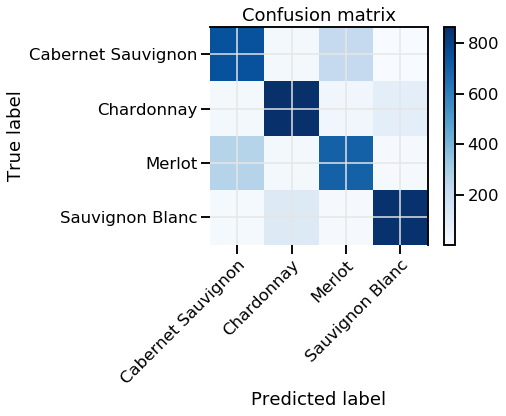

In [205]:
plot_cm(test['wine_variant'], pred)

In [207]:
pd.set_option('max_rows', 3000)
test[test['wine_variant']!=pred]

,wine_variant,review_text,tokens
8,Cabernet Sauvignon,"Sweet red fruits and still a bit of tannins, but everything is well integrated in this wine. It has some real nice cherry flavors and a hint of tobacco. The finish is smooth and silky.","[Sweet, red, fruits, and, still, a, bit, of, tannins, ,, but, everything, is, well, integrated, in, this, wine, ., It, has, some, real, nice, cherry, flavors, and, a, hint, of, tobacco, ., The, finish, is, smooth, and, silky, .]"
78,Cabernet Sauvignon,Probably at its peak right now. Popped and poured -a bit subdued at first but started to show fruit quickly. Built then leveled off. Very nice.,"[Probably, at, its, peak, right, now, ., Popped, and, poured, -a, bit, subdued, at, first, but, started, to, show, fruit, quickly, ., Built, then, leveled, off, ., Very, nice, .]"
126,Cabernet Sauvignon,"dark ruby and plenty of ""terrior"", nose is a bit earthy...must decant for at least 1 hour. after it opened up, it mellowed nicely and became very drinkable","[dark, ruby, and, plenty, of, "", terrior, "", ,, nose, is, a, bit, earthy, ..., must, decant, for, at, least, 1, hour, ., after, it, opened, up, ,, it, mellowed, nicely, and, became, very, drinkable]"
149,Cabernet Sauvignon,"I really hope to rate this higher over time, but at present hits me as so sweet that I'd rather pair it with bitter chocolate for dessert than any main course I can think of.","[I, really, hope, to, rate, this, higher, over, time, ,, but, at, present, hits, me, as, so, sweet, that, I, 'd, rather, pair, it, with, bitter, chocolate, for, dessert, than, any, main, course, I, can, think, of, .]"
166,Cabernet Sauvignon,"For $20 worth the money featuring cherry, plum, oak, vanilla and mild spices. Not a big wine and balanced. Drink now.","[For, $, 20, worth, the, money, featuring, cherry, ,, plum, ,, oak, ,, vanilla, and, mild, spices, ., Not, a, big, wine, and, balanced, ., Drink, now, .]"
191,Cabernet Sauvignon,"Berries, some vanilla on the nose. Sweet fruit on the palate. Tannins have almost faded. Probably should have drunk this earlier. Feels unbalanced now, too sweet without enough acidity. Still, very drinkable as aperitif; didn't enjoy as accompaniment to tuna steak yesterday.","[Berries, ,, some, vanilla, on, the, nose, ., Sweet, fruit, on, the, palate, ., Tannins, have, almost, faded, ., Probably, should, have, drunk, this, earlier, ., Feels, unbalanced, now, ,, too, sweet, without, enough, acidity, ., Still, ,, very, drinkable, as, aperitif, ;, did, n't, enjoy, as, accompaniment, to, tuna, steak, yesterday, .]"
233,Cabernet Sauvignon,"Surprisingly good. You just never know. Complex, nice blueberry, chocolate, and a bit smokey in the background.","[Surprisingly, good, ., You, just, never, know, ., Complex, ,, nice, blueberry, ,, chocolate, ,, and, a, bit, smokey, in, the, background, .]"
347,Cabernet Sauvignon,30 min decant. Loved the fruit bomb of a nose but noticed that quickly disappeared for some alcohol and oak. On the palate up front red fruit led to complete oak dominance. Just way too much oak for my palate. Day 2 and 3 got even more oakey which I found odd. Pass on this.,"[30, min, decant, ., Loved, the, fruit, bomb, of, a, nose, but, noticed, that, quickly, disappeared, for, some, alcohol, and, oak, ., On, the, palate, up, front, red, fruit, led, to, complete, oak, dominance, ., Just, way, too, much, oak, for, my, palate, ., Day, 2, and, 3, got, even, more, oakey, which, I, found, odd, ., Pass, on, this, .]"
368,Cabernet Sauvignon,Robust and very satisfying. Taste of plum and dark berries. Serve at 15C for best results. Very good wine for the price.,"[Robust, and, very, satisfying, ., Taste, of, plum, and, dark, berries, ., Serve, at, 15C, for, best, results, ., Very, good, wine, for, the, price, .]"
413,Cabernet Sauvignon,No decanting and drank immediately after opening. Color is still good with deep garnet and only a slight discoloration around the edge. Nose of mostly oak with hint of dark fruit and sligh

In [208]:
test[(test['wine_variant']!=pred)&
     (test['wine_variant']=='Chardonnay')]['review_text']

10053                                                                                                                                                                                                                                                                                        Tropical fruit nose - pineapples, mangoes with flinty undertones. Rich on the palate but not overwhelmingly so with tropical fruits again coming to the fore. Mineral edge; feels a little imbalanced. Sweetness on the finish.
10078                                                                                                                                                                                                                                                                                                                                              I've never met a Picq I didn't like, and this was no exception. Tropical and floral notes dominated by intense, wet-rock minerality. Showing very well d

In [209]:
best_lo.named_steps

{'countvectorizer': CountVectorizer(analyzer=<cyfunction identity at 0x000002CC39B529A0>,
         binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
         encoding='utf-8', input='content', lowercase=True, max_df=1.0,
         max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,
         stop_words=None, strip_accents=None,
         token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None),
 'tfidftransformer': TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True),
 'logisticregression': LogisticRegression(C=1.2067926406393288, class_weight=None, dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
           solver='warn', tol=0.0001, verbose=0, warm_start=False)}

In [210]:
X = np.array(best_lo.named_steps['countvectorizer'].get_feature_names())
terms = X[np.argsort(best_lo.named_steps['logisticregression'].coef_[0])]

In [212]:
terms[-50:]

array(['carries', 'coarse', 'minty', 'decant', 'Bordeaux', 'Again',
       'Decanted', 'Quilceda', 'peaked', 'cedar', 'WOTN', 'menthol',
       'pencil', 'Silver', 'Strip', 'tannin', 'steak', 'box', 'ribs',
       'Leap', 'ribeye', 'HSS', '97', 'Cork', 'filet', 'Tannins',
       'Montelena', 'napa', 'Insignia', 'port', 'hours', 'mint', '1994',
       'currants', 'tannins', 'bordeaux', 'blackcurrant', 'currant',
       'eucalyptus', 'CS', 'Napa', 'Cassis', 'Caymus', 'cassis', 'Cabs',
       'cabs', 'Cab', 'Cabernet', 'cabernet', 'cab'], dtype='<U120')

In [236]:
terms[37300:]

array(['claret', 'Think', 'Tobacco', 'Hillside', 'Howell', 'black',
       'Black', 'pairs', 'ribeyes', 'carries', 'coarse', 'minty',
       'decant', 'Bordeaux', 'Again', 'Decanted', 'Quilceda', 'peaked',
       'cedar', 'WOTN', 'menthol', 'pencil', 'Silver', 'Strip', 'tannin',
       'steak', 'box', 'ribs', 'Leap', 'ribeye', 'HSS', '97', 'Cork',
       'filet', 'Tannins', 'Montelena', 'napa', 'Insignia', 'port',
       'hours', 'mint', '1994', 'currants', 'tannins', 'bordeaux',
       'blackcurrant', 'currant', 'eucalyptus', 'CS', 'Napa', 'Cassis',
       'Caymus', 'cassis', 'Cabs', 'cabs', 'Cab', 'Cabernet', 'cabernet',
       'cab'], dtype='<U120')

In [246]:
len(X)

37359

#### What kinds of reviews is your classifier bad at classifying, and why?

- MultinomialNB: what and why<p>
    
This model performed bad at classifying same color wines, as between Chardonney and Sauvignon Blanc, and as between Merlot and carbenet Sauvignon. <br>
Based on the error analysis, I could find that the tokens that are generated from the simliar kinds corresponds much,
which make it hard to tell. <br>
In regards to MultinomialNB, as this model takes word frequencies and document length into account, but treats multiple
occurrences of a word as independent events, it ended up with mistakenly taking grammar entities as important, as we seen the terms analysis. This could be resulted from not tokenizing with grammar tags.

- BernoulliNB: what and why <p>
This model showed the similar result with the MultinomialNB, but slightly worse performing.<br> Its worse performance can be explained with its feature, not taking into account the number of times a word appears in a text or the length of a text, given the review texts are mostly short and have various ways of writing style within the same kind. <br>
    Although this need further research, as I haven't conducted error analysis due to its worst performance.

- Logistic Regression: what and why
The best performance I have achieved is by tuning parameters of the logistic regression model.<br>
I tried applying SVM with both L1 and L2 penalty, and varying C, to optimize its constraint.<br>
Based on the terms in my error analysis, most terms are classified with meaningful sense, better than MultinomialNB, which classified grammar terms. <br>
As tuning parameters, it turned out that L1 penalty is favored, seemingly because it only includes most predictive words, which cleared distinction between similar kinds. Given that L1 is favored and transforming with tf-idf showed much improved compared to none in logistic regression, taking terms that shows distinctive classification would be more effective way  than considering more terms in this review corpus.

## Discussion

- What have you learned about the task? <p>

: There ain't no such thing as a free lunch (TANSTAAFL)
: Breaking the performance of simplest method is harder, as much as the simplest method is favored in interpretability. <br>
: Tuning parameter is important, but makes not much difference considering its expensive computing time. <br>
: The same way of evaluation, such as applying the same fold in CV, should be maintained. <br>
: Even when number values, such as parameter or coefficients are given, visualizing or taking holistic view can give important insight in analysis.<br>
: Depending on dataset, taking occurrence is riskier than taking frequency, while frequency can be misled as in grammar terms. <br>
: One way to offset those irrelevant frequency is “Term Frequency times Inverse Document Frequency”, which downscale weights for words that occur in many documents in the corpus and are therefore less informative than those that occur only in a smaller portion of the corpus.
: The way you preprocess the data would be critical, although it's hard to know how at the beginning.

- Is the task hard or easy? What are the hard parts?<p>
: Because my knowledge in wine classification is shallow, I couldn't draw much insights from the error analysis.<br>
: It's hard to identify which parameter to apply for a specific method, rather than tuning the parameter, which is only matter of time.<br>
: Some reviews could be classified into more than one category even when I read, which partly because my shallow knowledge in this area, or becuase those reviews are genuinely ambiguous. I wasn't sure if I leave those review unclear or how should I analyze them. In this analysis, I left them rather than trying to figure out how to fit them, afraid of over fitting.


- What would you need to do to score better than 90% accuracy?

1) Tokenize NER, or lemma <br>
: With named entity, the classifier could learn what entity is critical in classfication. <br>
: With lemma, the classifier could ignore some grammar words, as shown in my 'MultinomialNB classifier' (best_nb) <p>
    
2) Combine with different source of information <br>
: As seen in misclassification examples, many reviews are even ambiguous to people, which are almost impossible to tell based sorely on reviews. With some other informations such as '% of ingredients', it would facilitate the accuracy.